# Práctica 1: Aprendizaje automático

__Fecha de entrega: 13 de marzo de 2022__

El objetivo de esta práctica es aplicar los distintos algoritmos de aprendizaje automático disponibles en la scikit-learn [sklearn](https://scikit-learn.org/stable/) sobre varios conjuntos de datos y aprender a interpretar los resultados obtenidos. La práctica consta de 3 notebooks que se entregarán simultáneamente en la tarea de entrega habilitada en el Campus  Virtual.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

# Apartado 1: Clustering

__Número de grupo: 15__

__Nombres de los estudiantes: Javier Sande Ríos y Mario Sanz Guerrero__

## 1) Carga del conjunto de datos

Crea un dataframe a partir del fichero `prestamos.csv` que se proporciona junto con la práctica. 

El conjunto de datos contiene por cada fila los datos de un préstamo que fue concedido por una empresa de crédito p2p. Las variables que caracterizan el préstamo son las siguientes:
  - `loan_amnt` es la cantidad de dinero solicitada en dólares
  - `purpose` es el propósito para el que se solicitó el préstamo
  - `revenue` son los ingresos anuales en dólares de la persona que solicitó el préstamos
  - `dti_n` es el porcentaje de endeudamiento sobre los ingresos anuales de la persona que solicitó el préstamo
  - `fico_n` se trata de un indicador de solvencia de la persona que solicitó el préstamo. A mayor puntuación, mayor solvencia, y además se cuenta con estos rangos orientativoss:
    - 300-550: Pobre
    - 550-620: Subprime (alto riesgo)
    - 620-680: Crédito aceptable
    - 680-740: Buen crédito
    - 740-850: Excelente crédito

  -`home_ownership_n` es una variable categórica que indica la situación de vivienda en la que vive la persona solicitante
    - `OWN` es en propiedad
    - `MORTAGAGE` indica que está hipotecada
    - `RENT` indica que vive en alquiler
    - `OTHER` es una categoría que agrega otras posibilidades

- `emp_length` es una variable ordinal, no es estrictamente numérica, ya que el valor 0 denota que no consta información, los valores entre 1 y 10 indican una permanencia inferior a X años, y el valor 11 indica una permanencia superior a 10 años.
- `Default` es la variable que usaremos como **variable objetivo** del conjunto de datos e indica si la persona incumplió (incurrió en *default*) o no el préstamo.


Como pandas no tiene forma de saber que las variables `home_ownership_n`, `emp_length` y `Default` son en realidad categóricas, debes indicárselo tú.

In [6]:
import numpy as np
import pandas as pd

In [12]:
# La función read_csv ya nos devuelve un DataFrame, así que no hace falta convertirlo
df = pd.read_csv('prestamos.csv')
df

,loan_amnt,purpose,revenue,dti_n,fico_n,home_ownership_n,emp_length_n,Default
0,32000,car,135000.0,18.93,687.0,MORTGAGE,1,0
1,32000,car,90000.0,9.29,822.0,MORTGAGE,10,1
2,30000,car,95000.0,1.34,722.0,RENT,11,0
3,25750,car,230000.0,6.42,747.0,MORTGAGE,11,0
4,25200,car,72000.0,30.95,692.0,OWN,11,0
...,...,...,...,...,...,...,...,...
13789,1275,vacation,42000.0,31.89,792.0,RENT,0,0
13790,1200,vacation,36000.0,12.27,747.0,MORTGAGE,8,0
13791,1000,vacation,76000.0,25.26,702.0,MORTGAGE,11,0
13792,1000,vacation,32000.0,17.70,747.0,MORTGAGE,0,0


Del dataframe anterior, vamos a crear dos dataframes nuevos: uno que solo tenga variables numéricas y otro que solo tenga variables categóricas.

In [16]:
df_num = df.drop(['home_ownership_n', 'emp_length_n', 'Default'], axis=1)
df_num

,loan_amnt,purpose,revenue,dti_n,fico_n
0,32000,car,135000.0,18.93,687.0
1,32000,car,90000.0,9.29,822.0
2,30000,car,95000.0,1.34,722.0
3,25750,car,230000.0,6.42,747.0
4,25200,car,72000.0,30.95,692.0
...,...,...,...,...,...
13789,1275,vacation,42000.0,31.89,792.0
13790,1200,vacation,36000.0,12.27,747.0
13791,1000,vacation,76000.0,25.26,702.0
13792,1000,vacation,32000.0,17.70,747.0


In [17]:
df_cat = df[['home_ownership_n', 'emp_length_n', 'Default']]
df_cat

,home_ownership_n,emp_length_n,Default
0,MORTGAGE,1,0
1,MORTGAGE,10,1
2,RENT,11,0
3,MORTGAGE,11,0
4,OWN,11,0
...,...,...,...
13789,RENT,0,0
13790,MORTGAGE,8,0
13791,MORTGAGE,11,0
13792,MORTGAGE,0,0


## 2) Análisis de los datos

### 2.1) Numéricos

Analiza razonadamente las distribuciones de cada una de las variables numéricas (medias, desviaciones típicas, rangos, ...) y las principales relaciones entre pares de variables (diagrama de dispersión, coeficientes de correlación, ...).

**Variables numéricas**

In [18]:
df_num.describe()

,loan_amnt,revenue,dti_n,fico_n
count,13794.000000,1.379400e+04,13794.000000,13794.000000
mean,14507.833116,7.973730e+04,18.825106,699.106822
std,9037.938271,5.646358e+04,9.795986,32.825754
min,1000.000000,7.000000e+03,0.000000,662.000000
25%,7300.000000,4.800000e+04,12.200000,672.000000
50%,12000.000000,6.800000e+04,18.085000,692.000000
75%,20000.000000,9.700000e+04,24.757500,717.000000
max,40000.000000,1.650000e+06,190.870000,847.500000


**Análisis:** 

**Diagrama de dispersión**

array([[<AxesSubplot:xlabel='loan_amnt', ylabel='loan_amnt'>,
        <AxesSubplot:xlabel='revenue', ylabel='loan_amnt'>,
        <AxesSubplot:xlabel='dti_n', ylabel='loan_amnt'>,
        <AxesSubplot:xlabel='fico_n', ylabel='loan_amnt'>],
       [<AxesSubplot:xlabel='loan_amnt', ylabel='revenue'>,
        <AxesSubplot:xlabel='revenue', ylabel='revenue'>,
        <AxesSubplot:xlabel='dti_n', ylabel='revenue'>,
        <AxesSubplot:xlabel='fico_n', ylabel='revenue'>],
       [<AxesSubplot:xlabel='loan_amnt', ylabel='dti_n'>,
        <AxesSubplot:xlabel='revenue', ylabel='dti_n'>,
        <AxesSubplot:xlabel='dti_n', ylabel='dti_n'>,
        <AxesSubplot:xlabel='fico_n', ylabel='dti_n'>],
       [<AxesSubplot:xlabel='loan_amnt', ylabel='fico_n'>,
        <AxesSubplot:xlabel='revenue', ylabel='fico_n'>,
        <AxesSubplot:xlabel='dti_n', ylabel='fico_n'>,
        <AxesSubplot:xlabel='fico_n', ylabel='fico_n'>]], dtype=object)

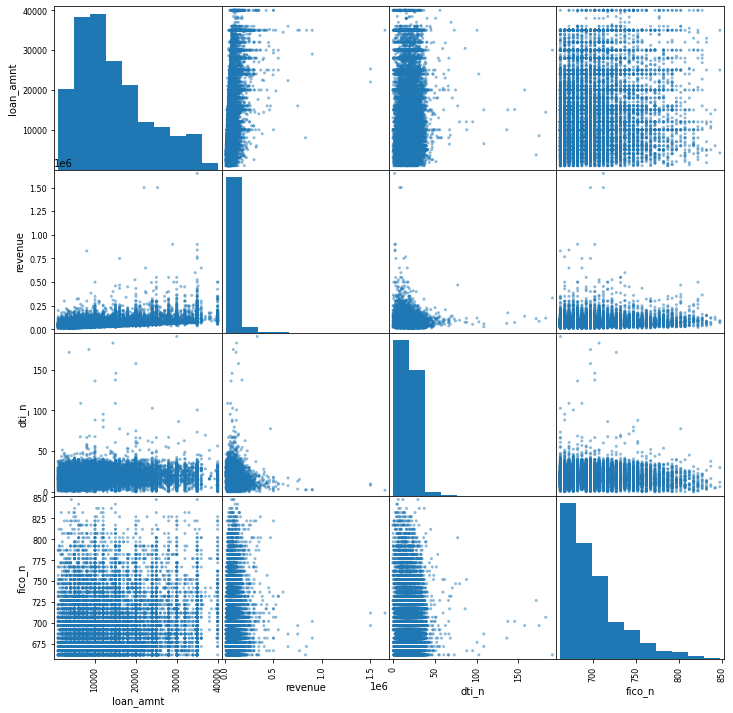

In [24]:
from pandas.plotting import scatter_matrix
%matplotlib inline

scatter_matrix(df_num, figsize = (12, 12), diagonal = 'hist')

**Análisis:** 

**Coeficientes de correlación entre pares de variables**

In [19]:
df_num.corr()

,loan_amnt,revenue,dti_n,fico_n
loan_amnt,1.000000,0.424460,0.034134,0.090869
revenue,0.424460,1.000000,-0.137616,0.091204
dti_n,0.034134,-0.137616,1.000000,-0.057580
fico_n,0.090869,0.091204,-0.057580,1.000000


**Análisis:** 


### 2.2) Categóricos

Analiza razonadamente las distribuciones de los valores de las variables categóricas incluyendo un diagrama de frecuencias y comentando lo más destacable.

<AxesSubplot:>

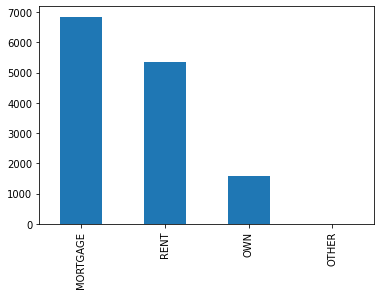

In [41]:
df_cat['home_ownership_n'].value_counts().plot.bar()

<AxesSubplot:>

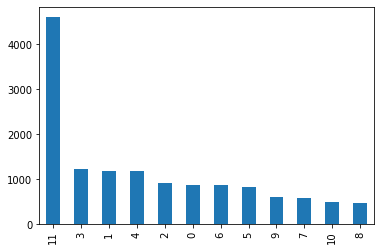

In [38]:
df_cat['emp_length_n'].value_counts().plot.bar()

<AxesSubplot:>

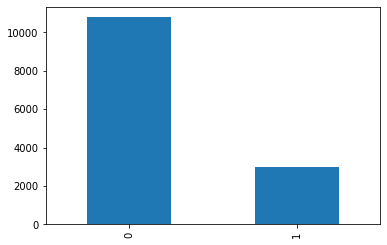

In [39]:
df_cat['Default'].value_counts().plot.bar()

**Análisis:** 

## 3) Preprocesar los datos

Para el clustering vamos a trabajar solamente con las variables verdaderamente numéricas. Crea un nuevo dataframe que sólo contenga las variables `loan_amnt`, `revenue`, `dti_n` y `fico_n`.

Teniendo en cuenta que vamos a utilizar el algoritmo k-Means para encontrar grupos de préstamos similares, explica razonadamente si es necesario o no cambiar la escalas de los datos y si a priori es mejor reescalarlos (MinMaxScaler) o estandarizarlos (StandarScaler).

Si decides preprocesarlos, accede al array interno del dataframe y crea un nuevo array con los datos escalados.

## 4) Encontrar el número óptimo de clusters

Decide razonadamente el número óptimo de clusters en el rango 2..10. Ten en cuenta que para interpretar los datos no nos interesa tampoco tener un número excesivo de clusters. Para hacerlo calcula y pinta el diagrama del codo, el índice davies_boulding y el coeficiente silhouette en función del número de clusters.

## 5) Descripción de los clusters

Describe los clusters que has obtenido en el apartado anterior. Si te han salido más de 3, elige 3 de ellos que sean bastante diferentes entre sí. 

Para hacerlo estudia sus descriptores estadísticos y dales un sentido dentro del contexto del problema. ¿Qué perfil de préstamos quedan en cada cluster? Según dicho perfil, ¿qué cluster te parece que tendrá una mayor tasa de "default"? Corrobóralo calculando para cada cluster la proporción de préstamos que acabaron en "default".

Pinta el diagrama de dispersión en función de cada par de variables usando colores diferentes para cada cluster. ¿Qué clusters se separan mejor y en función de qué variables? ¿y cuáles se confunden más?

__Cuidado__: para poder interpretar correctamente los datos necesitas que estén en su escala original. Si decidiste escalar los datos, deberás ejecutar k-Means con los datos escalados pero asignar las etiquetas de clusters al conjunto de datos inicial. En este caso es muy sencillo porque el algoritmo no cambia el orden de los datos así que puedes crear directamente una nueva columna en el dataframe original con esas etiquetas. Puede que aparezca un SettingWithCopyWarning por asignar una nueva columna en un dataframe que es una vista de otro dataframe. Puedes ignorar este aviso o puedes hacer una copia del dataframe con `copy` para que no comparta memoria con el otro.